# Data Collection

The dataset we are planning to use for our problem is called LRS3 (Lip Reading Sentences 3)

It was found and downloaded from the website that hosts the dataset (among others): https://www.robots.ox.ac.uk/~vgg/data/lip_reading/lrs3.html

As the dataset itself is fairly large, only a few subsections have been downloaded and will be visualized in this notebook.

## Dataset Summary

The LRS3 dataset consists of thousands of spoken sentences taken from recordings of TED and TEDX videos. The videos are already generated using some facial tracking, so the faces of the speakers are in the center of all the videos. In addition to the videos, each video has a corresponding text file that contains the transcript of what the speaker said in the short video.

The dataset is split up into three sets: Pre-train, Trainval, and Test

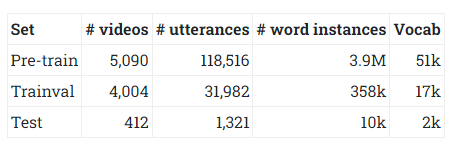

## Taking a look at the data

After uploading a few of the directories containing some of the dataset to Google Drive, we can take a look at some of the videos and transcripts

In [ ]:
!apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [ ]:
import glob
import os
import torch
import torchvision
import cv2
from google.colab import drive
from google.colab.patches import cv2_imshow

In [ ]:
drive.mount('/content/gdrive', force_remount=False)

os.chdir('/content/gdrive/My Drive/lipreading')
os.listdir('data')

Mounted at /content/gdrive


['pretrain', 'test', 'trainval']

In [ ]:
partition = 'trainval'
video_paths = glob.glob(f'data/{partition}/*/*.mp4')
video_paths

['data/trainval/ZZodGSsPrRE/50002.mp4', 'data/trainval/ZZodGSsPrRE/50003.mp4']

In [ ]:
def get_frames(video_path, desired_frames=None):
  video_cap = cv2.VideoCapture(video_path)

  fps = video_cap.get(5)
  frame_count = video_cap.get(7)
  
  if desired_frames:
    if desired_frames > frame_count:
      print(f'Requested {desired_frames} frames, the video only contains {frame_count} frames')
      return []

  print('FPS: ', fps)
  print('Frames: ', frame_count)

  frames = []

  frame_limit = frame_count if not desired_frames else desired_frames
  for i in range(int(frame_limit)):
    ret, val = video_cap.read()

    if ret:
      frames.append(val)
    else:
      print('Error occured')
      break

  video_cap.release()
  return frames

In [ ]:
def visualize_frames(frames):
  for f in frames:
    cv2_imshow(f)

FPS:  25.0
Frames:  61.0
(224, 224, 3) 61


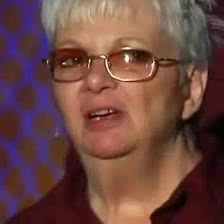

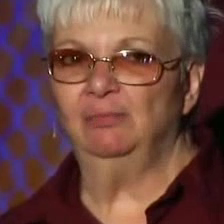

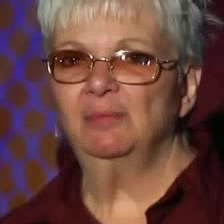

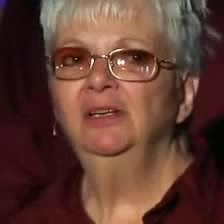

In [ ]:
frames = get_frames('data/trainval/ZZodGSsPrRE/50002.mp4')

print(frames[0].shape, len(frames))
visualize_frames(frames[::20])

In the cell above, we can see that the this specific video is recorded at 25 FPS and contains 32 frames of size (224 x 224 x 3)

To see the corresponding transcript for this video, the path to the transcript text file is the same path, but with the .txt file extension rather than the .mp4

In [ ]:
with open('data/trainval/ZZodGSsPrRE/50002.txt', 'r') as f:
  print(f.read())

Text:  MY NAME IS DEBRA BROWN
Conf:  4



After downloading all the data to the cluster, and using Python's glob, we have 31,982 videos from the Train set, 1,321 videos from the test set, and 118,516 videos from the pretrain set. 

They are all recorded at 25.0 fps nd have a resolution of (224 x 224 x 3). The videos have differing lengths.

In [ ]:
partition = 'pretrain'
video_paths = glob.glob(f'data/{partition}/*/*.mp4')
len(video_paths)

5

In [ ]:
transcript_example_path = video_paths[0].replace('mp4', 'txt')

with open(transcript_example_path, 'r') as f:
  lines = f.readlines()

  word_alignments = []
  for line in lines[4:]:
    word_alignments.append(line[:-2].split(' '))

word_alignments

[['OUTFIT', '0.08', '0.58', '4.'],
 ["I'M", '4.05', '4.38', '5.'],
 ['PASSIONATE', '4.38', '4.86', '3.'],
 ['ABOUT', '4.86', '5.20', '2.'],
 ['CHANGING', '5.20', '5.65', '2.'],
 ['THE', '5.65', '5.78', '1.'],
 ['FASHION', '5.78', '6.14', '4.'],
 ['INDUSTRY', '6.14', '6.69', '0.'],
 ['ABOUT', '7.24', '7.54', '2.'],
 ['PROVIDING', '7.54', '8.10', '4.'],
 ['SUSTAINABLE', '8.10', '8.71', '5.'],
 ['CLOTHING', '8.71', '9.04', '7.'],
 ['OPTIONS', '9.04', '9.55', '3.'],
 ['AND', '9.93', '10.04', '13.'],
 ['SUPPORTING', '10.04', '10.57', '8.'],
 ['DESIGNERS', '10.57', '11.08', '4.'],
 ['WHO', '11.08', '11.28', '3.'],
 ['ARE', '11.28', '11.35', '2.'],
 ['DOING', '11.35', '11.79', '2.'],
 ['THE', '11.79', '11.90', '3.'],
 ['RIGHT', '11.90', '12.22', '6.'],
 ['THING', '12.25', '12.56', '2.'],
 ['EVERYTHING', '13.59', '14.15', '2.'],
 ['YOU', '14.15', '14.23', '3.'],
 ['ARE', '14.23', '14.36', '6.'],
 ['WEARING', '14.36', '14.67', '4.'],
 ['TODAY', '14.67', '15.38', '3.'],
 ['HAS', '15.78', '16.00'

In [ ]:
segment_length_seconds = 16/25
print('Segment length in seconds: ', segment_length_seconds)

def mine_examples(video_paths, segment_length_frames=16, fps=25, desired_segments=4):
  transcript_paths = [x.replace('mp4', 'txt') for x in video_paths]

  seg_length_seconds = segment_length_frames / fps
  segment_increments = [x * (seg_length_seconds) for x in range(desired_segments+1)]

  suitable_video_paths = []
  suitable_word_sets = []

  for vid_path, transcript_path in zip(video_paths, transcript_paths):

    word_alignments = []
    with open(transcript_path, 'r') as f:
      lines = f.readlines()
      
      for line in lines[4:]:
        word_alignments.append(line[:-2].split(' '))
    
    word_durations = [float(x[2]) - float(x[1]) for x in word_alignments]

    for i in range(len(word_durations) - desired_segments):
      query_word_durations = word_durations[i:i+desired_segments]
      query_word_alignments = word_alignments[i:i+desired_segments]

      one_too_long = False
      for seg in query_word_durations:
        if seg > seg_length_seconds:
          one_too_long = True
          break

      if one_too_long: 
        continue

      one_doesnt_fit = False
      start = float(query_word_alignments[0][1])
      for i in range(desired_segments):
        if (float(query_word_alignments[i][1]) < start + segment_increments[i] or float(query_word_alignments[i][2]) > start + segment_increments[i+1]):
          one_doesnt_fit = True
          break

      if one_doesnt_fit:
        continue

      suitable_word_sets.append(query_word_alignments)
      suitable_video_paths.append(vid_path)

  return suitable_video_paths, suitable_video_paths

Segment length in seconds:  0.64


In [ ]:
mine_examples(video_paths)

([], [])